In [1]:
import rpy2
import rpy2.robjects.lib.ggplot2 as ggplot2
import rpy2.robjects as ro
from rpy2.robjects.packages import importr
base = importr('base')

# the base of rpy2 plotting is matplotlib, thus we need to declare
# it inline in order to see the plots in the notebook
%matplotlib inline

# we need to activate the automatic conversion for pandas
from rpy2.robjects import pandas2ri
pandas2ri.activate()

# load the needed extension for the %%R cell magic
%load_ext rpy2.ipython

import numpy as np
import pandas as pd

%config IPCompleter.greedy=True

import matplotlib.pylab as plt
plt.rcParams['figure.dpi'] = 200

In [24]:
outdir = 'kafka-tput-26b6a76'
inters = [5, 6, 7, 8, 9, 10, 12, 15, 20, 25, 50, 75, 100]
batch_sizes = [8192, 16384, 32768, 65536, 98304]
fname = "exp-kafka-be-{}ms-{}batch-1rcvr.data"

In [25]:
df = None
for inter in inters:
    for bsize in batch_sizes:
        fn = f"../{outdir}/{fname.format(inter, bsize)}"
        try:
            file_df = pd.read_csv(fn, sep=" ")
            file_df['interarrival'] = inter
            file_df['batch_size'] = bsize
            if df is None:
                df = file_df
            else:
                df = df.append(file_df)
        except Exception as e:
            print(f"skip {fn}, {e}")
            continue

df

,mode,provider,inter_request_ms,num_msgs,elapsed_us,msg_send_time,req_num,req_latency_us,req_orderedness,interarrival,batch_size
0,BestEffort,kafka,5,1000,10553965,239925,20,905627,0.020,5,8192
1,BestEffort,kafka,5,1000,10553965,275189,23,870537,0.022,5,8192
2,BestEffort,kafka,5,1000,10553965,496633,42,649197,0.040,5,8192
3,BestEffort,kafka,5,1000,10553965,507716,43,638220,0.040,5,8192
4,BestEffort,kafka,5,1000,10553965,764790,65,381249,0.061,5,8192
...,...,...,...,...,...,...,...,...,...,...,...
995,BestEffort,kafka,100,1000,104998480,106209529,995,6006,0.000,100,98304
996,BestEffort,kafka,100,1000,104998480,106316740,996,6127,0.000,100,98304
997,BestEffort,kafka,100,1000,104998480,106423019,997,6027,0.000,100,98304
998,BestEffort,kafka,100,1000,104998480,106529203,998,6120,0.000,100,98304


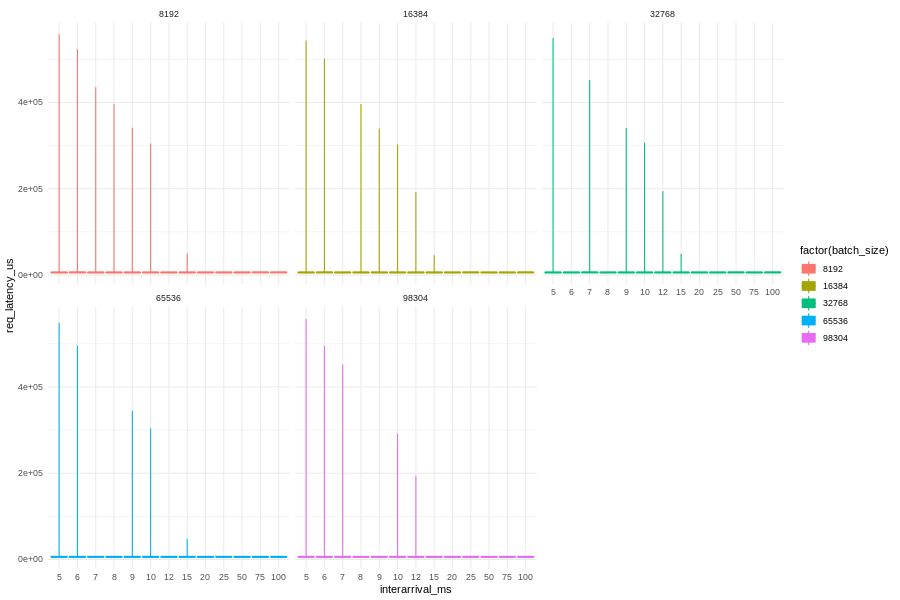

In [27]:
%%R -i df -w 900 -h 600

library(ggplot2)

f <- function(x) {
  r <- quantile(x, probs = c(0.05, 0.25, 0.5, 0.75, 0.95))
  names(r) <- c("ymin", "lower", "middle", "upper", "ymax")
  r
}

ggplot(df, aes(x=factor(interarrival), y=req_latency_us, color=factor(batch_size), fill=factor(batch_size))) + 
  stat_summary(fun.data = f, geom="boxplot", position=position_dodge(width=1)) +
    facet_wrap(~batch_size) +
    xlab("interarrival_ms") +
    theme_minimal()
